In [1]:
%load_ext autoreload
%autoreload 2

# Comment to make figures visible in html version of the notebook
# %matplotlib notebook

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os

from functools import lru_cache, reduce
from zwad.ad import ZtfAnomalyDetector


matplotlib.rcParams['font.size'] = 14


algos_for_fields = {
    'm31': ['iso', 'gmm', 'svm', 'lof'],
    'deep': ['iso', 'gmm', 'svm'],
    'disk': ['iso', 'gmm'],
}

jobs = '4'
data_dir = os.path.join('..', 'data')
fake_dir = os.path.join(data_dir, 'fakes')
scalings = ['std', 'pca', 'pca15', 'pca24', 'norm']
styles = {'iso': '--', 'gmm': '-', 'svm': '-.', 'lof': ':', 'union': ':'}
colors = {
    'iso': (230/255, 159/255, 0),
    'gmm': (86/255, 180/255, 233/255),
    'svm': (0, 158/255, 115/255),
    'lof': (213/255, 94/255, 0),
    'union': (204/255, 121/255, 167/255),
}


# Contents

* [Code](#Code)
* [Generating score files with different scalings](#Generating-score-files-with-scalings)
* [Compare fake detection with different scalings](#Compare-fake-detection-with-scalings)
* [Generating score files for different fields](#Generating-score-files-for-different-fields)
* [Plot the fake detection curves for fields](#Plot-the-fake-detection-curves-for-fields)
* [Plot the cumulative score distributions](#Plot-the-cumulative-score-distributions)

# Code

In [3]:
@lru_cache()
def load_fake_names(fake_filename):
    """
    Just load the fake names, in tuple.
    """
    return tuple(pd.read_csv(fake_filename, index_col=0)['0'])


def fake_indices(scores, fake_names):
    """
    Calculate fake indices
    
    Parameters
    ----------
    scores: Scores of all the objects, including fakes at the end.
    
    fake_names: Tuple of fake object names.
    
    Return
    ------
    Table with 'name' and 'order' columns, sorted by 'order'.
    """
    fake_n = len(fake_names)
    index = np.argsort(scores)
    fake_index = np.argsort(index)[-fake_n:]  # Guess what's going on here ;)
    fake_table = pd.DataFrame({'order': fake_index, 'name': fake_names})
    return fake_table.sort_values(by='order').reset_index(drop=True)


def union_fakes(algo_to_fakes):
    """
    Union the different algorithms' fake detection curves to one
    """
    
    order = []
    for fake_table in algo_to_fakes.values():
        order.append(fake_table.sort_values(by='name')['order'].to_numpy())

    name = sorted(fake_table['name'])
    min_order = np.array(order).min(axis=0)

    table = pd.DataFrame({'order': min_order, 'name': name})
    table = table.sort_values(by='order').reset_index(drop=True)
    
    return table


def make_fake_tables(scores_dir, fake_dir, field, algos):
    """
    Read the score files with fakes. Read the fake descriptions.
    Make the tables with score oderings.
    """
    fake_tables = {}
    for algo in algos:
        scores = np.memmap(os.path.join(scores_dir, 'score_{}_{}_fake.dat'.format(field, algo)), dtype=np.float64)
        fake_names = load_fake_names(os.path.join(fake_dir, 'fakes_{}_fake.csv'.format(field)))
        fake_tables[algo] = fake_indices(scores, fake_names)
    
    fake_tables['union'] = union_fakes(fake_tables)
    return fake_tables

# Generating score files with scalings

In [4]:
# Generate the score files for m31 field with different scalings

field = 'm31'
for scaling in scalings:
    # Put score files in different directories for future comparison
    scores_dir = os.path.join(data_dir, 'scores_' + scaling)
    os.makedirs(scores_dir, exist_ok=True)

    for algo in algos_for_fields[field]:
        real_args = ['--oid', os.path.join(data_dir, 'oid_{}.dat'.format(field)),
                     '--feature', os.path.join(data_dir, 'feature_{}.dat'.format(field)),]
        fake_args = ['--oid', os.path.join(fake_dir, 'oid_{}_fake.dat'.format(field)),
                     '--feature', os.path.join(fake_dir, 'feature_{}_fake.dat'.format(field)),]
        
        score_file = os.path.join(scores_dir, 'score_{}_{}_fake.dat'.format(field, algo))
        score_args = ['--output', score_file]
        
        if os.path.exists(score_file):
            continue
        
        args = ['--jobs', jobs, '--scale', scaling, '--classifier', algo]
        args += real_args + fake_args + score_args
        ZtfAnomalyDetector(args).run()

# Compare fake detection with scalings

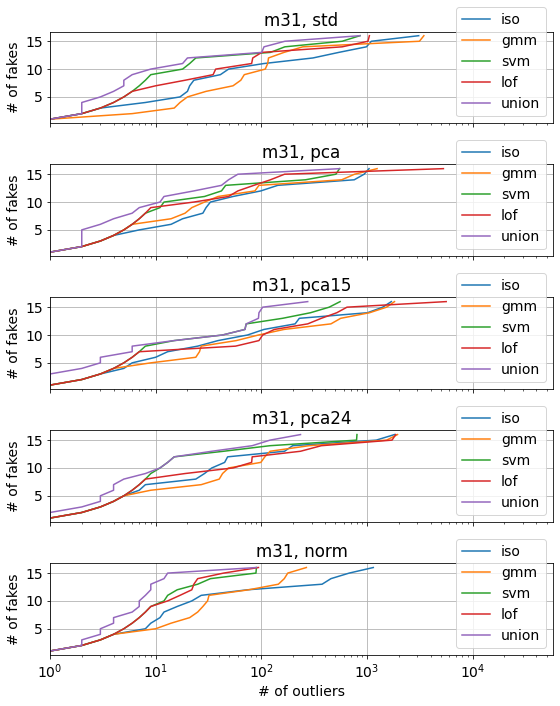

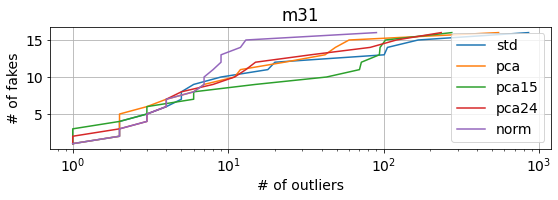

In [5]:
# Plot the fake curves

field = 'm31'
oid_len = os.stat(os.path.join(data_dir, 'oid_m31.dat')).st_size // 8
fig1, ax = plt.subplots(nrows=len(scalings), sharex=True, figsize=(8, 10))
fig2, bx = plt.subplots(figsize=(8, 3))
for i, scaling in enumerate(scalings):
    scores_dir = os.path.join(data_dir, 'scores_' + scaling)
    fake_tables = make_fake_tables(scores_dir, fake_dir, field, algos_for_fields[field])

    for algo, fake_table in fake_tables.items():
        ax[i].plot(fake_table['order'] + 1, np.arange(len(fake_table)) + 1, label=algo)

    ax[i].set(title='{}, {}'.format(field, scaling), ylabel='# of fakes')
    ax[i].set(xscale='log', xlim=[1, oid_len])
    ax[i].legend(loc='lower right')
    ax[i].grid()
    
    fake_table = fake_tables['union']
    bx.plot(fake_table['order'] + 1, np.arange(len(fake_table)) + 1, label=scaling)
#    display(pd.DataFrame({k: v['name'] for k, v in algo_to_fakes.items()}))

ax[-1].set(xlabel='# of outliers')
fig1.tight_layout()

bx.set(title='m31', ylabel='# of fakes', xlabel='# of outliers', xscale='log')
bx.legend(loc='lower right')
bx.grid()
fig2.tight_layout()

# Generating score files for different fields

## Score files may be downloaded
```shell
cd ../data
wget "http://sai.snad.space/ztf/scores.tar.gz" -O - | tar -zxf -
```

## Or they may be generated

In [6]:
# Generate the score files for m31 field with different scalings
# WARNING: that may be a long run

scaling = 'std'
scores_dir = os.path.join(data_dir, 'scores')
os.makedirs(scores_dir, exist_ok=True)

for field in algos_for_fields.keys():
    for algo in algos_for_fields[field]:
        real_args = ['--oid', os.path.join(data_dir, 'oid_{}.dat'.format(field)),
                     '--feature', os.path.join(data_dir, 'feature_{}.dat'.format(field)),]
        fake_args = ['--oid', os.path.join(fake_dir, 'oid_{}_fake.dat'.format(field)),
                     '--feature', os.path.join(fake_dir, 'feature_{}_fake.dat'.format(field)),]

        score_file = os.path.join(scores_dir, 'score_{}_{}_fake.dat'.format(field, algo))
        score_args = ['--output', score_file]

        if os.path.exists(score_file):
            continue

        args = ['--jobs', jobs, '--scale', scaling, '--classifier', algo]
        args += real_args + fake_args + score_args
        ZtfAnomalyDetector(args).run()

# Plot the fake detection curves for fields

,iso,gmm,svm,lof,union
0,step,step,step,step,step
1,ZTF18abhjrcf_format_r,Gaia16aye_3_format_r,MACHO-6.6696.60_format_R,flat,MACHO-6.6696.60_format_R
2,Gaia16aye_3_format_r,ZTF18abhjrcf_format_r,Gaia16aye_3_format_r,MACHO-6.6696.60_format_R,ZTF18abhjrcf_format_r
3,ZTF18abaqxrt_format_r,MACHO-6.6696.60_format_R,ZTF18abhjrcf_format_r,flat_noise,flat
4,MACHO-6.6696.60_format_B,ZTF18abaqxrt_format_r,ZTF18abaqxrt_format_r,Gaia16aye_2_format_r,Gaia16aye_3_format_r
5,ZTF18aaztjyd_format_r,Gaia16aye_format_r,MACHO-6.6696.60_format_B,MACHO-6.6696.60_format_B,flat_noise
6,Gaia16aye_format_r,MACHO-6.6696.60_format_B,flat,Gaia16aye_3_format_r,Gaia16aye_2_format_r
7,Gaia16aye_2_format_r,Gaia16aye_2_format_r,Gaia16aye_2_format_r,ZTF18abaqxrt_format_r,ZTF18abaqxrt_format_r
8,MACHO-6.6696.60_format_R,flat,Gaia16aye_format_r,ZTF18acskgwu_format_r,MACHO-6.6696.60_format_B
9,ZTF18acskgwu_format_r,flat_noise,ZTF18acskgwu_format_r,ZTF18abhjrcf_format_r,Gaia16aye_format_r


,order,name
0,0,step
1,1,MACHO-6.6696.60_format_R
2,1,ZTF18abhjrcf_format_r
3,1,flat
4,2,Gaia16aye_3_format_r
5,3,flat_noise
6,4,Gaia16aye_2_format_r
7,4,ZTF18abaqxrt_format_r
8,5,MACHO-6.6696.60_format_B
9,8,Gaia16aye_format_r


,iso,gmm,svm,union
0,Gaia16aye_3_format_r,step,step,step
1,ZTF18abhjrcf_format_r,Gaia16aye_2_format_r,Gaia16aye_2_format_r,Gaia16aye_2_format_r
2,step,Gaia16aye_format_r,Gaia16aye_3_format_r,Gaia16aye_3_format_r
3,Gaia16aye_2_format_r,Gaia16aye_3_format_r,MACHO-6.6696.60_format_R,ZTF18abhjrcf_format_r
4,Gaia16aye_format_r,ZTF18abaqxrt_format_r,Gaia16aye_format_r,Gaia16aye_format_r
5,ZTF18acskgwu_format_r,ZTF18abhjrcf_format_r,ZTF18abaqxrt_format_r,MACHO-6.6696.60_format_R
6,ZTF18ablruzq_format_r,MACHO-6.6696.60_format_R,MACHO-6.6696.60_format_B,ZTF18abaqxrt_format_r
7,MACHO-6.6696.60_format_R,OGLE-LMC-CEP-0227_format_I,flat,MACHO-6.6696.60_format_B
8,ZTF18aaztjyd_format_r,ZTF18acskgwu_format_r,ZTF18abhjrcf_format_r,flat
9,ZTF18abaqxrt_format_r,flat,ZTF18acskgwu_format_r,ZTF18acskgwu_format_r


,order,name
0,0,step
1,2,Gaia16aye_2_format_r
2,2,Gaia16aye_3_format_r
3,3,ZTF18abhjrcf_format_r
4,4,Gaia16aye_format_r
5,4,MACHO-6.6696.60_format_R
6,7,ZTF18abaqxrt_format_r
7,11,MACHO-6.6696.60_format_B
8,13,flat
9,19,ZTF18acskgwu_format_r


,iso,gmm,union
0,step,step,step
1,ZTF18abhjrcf_format_r,Gaia16aye_3_format_r,Gaia16aye_3_format_r
2,MACHO-6.6696.60_format_B,Gaia16aye_format_r,ZTF18abhjrcf_format_r
3,Gaia16aye_format_r,ZTF18abhjrcf_format_r,Gaia16aye_format_r
4,MACHO-6.6696.60_format_R,OGLE-LMC-CEP-0227_format_V,MACHO-6.6696.60_format_B
5,Gaia16aye_3_format_r,ZTF18aaztjyd_format_r,OGLE-LMC-CEP-0227_format_V
6,ZTF18aaztjyd_format_r,MACHO-6.6696.60_format_B,ZTF18aaztjyd_format_r
7,ZTF18abaqxrt_format_r,MACHO-6.6696.60_format_R,MACHO-6.6696.60_format_R
8,ZTF18acskgwu_format_r,ZTF18abaqxrt_format_r,ZTF18abaqxrt_format_r
9,Gaia16aye_2_format_r,Gaia16aye_2_format_r,Gaia16aye_2_format_r


,order,name
0,6,step
1,30,Gaia16aye_3_format_r
2,44,ZTF18abhjrcf_format_r
3,45,Gaia16aye_format_r
4,65,MACHO-6.6696.60_format_B
5,65,OGLE-LMC-CEP-0227_format_V
6,70,ZTF18aaztjyd_format_r
7,130,MACHO-6.6696.60_format_R
8,190,ZTF18abaqxrt_format_r
9,198,Gaia16aye_2_format_r


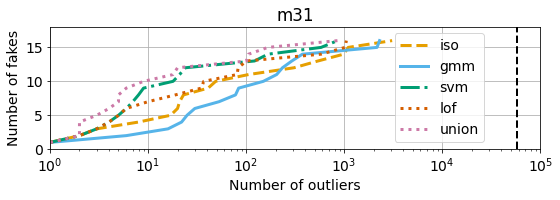

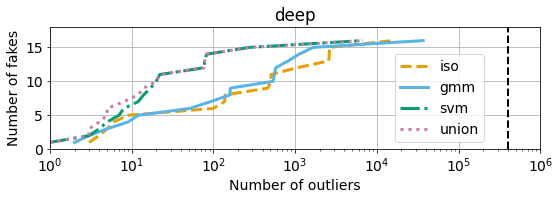

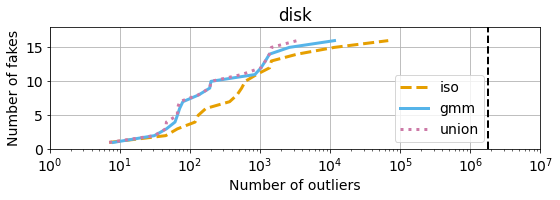

In [7]:
# Plot the fake curves for fields

scores_dir = os.path.join(data_dir, 'scores')
for field in algos_for_fields.keys():
    oid_len = os.stat(os.path.join(data_dir, 'oid_{}.dat'.format(field))).st_size // 8

    fake_tables = make_fake_tables(scores_dir, fake_dir, field, algos_for_fields[field])

    fig, ax = plt.subplots(figsize=(8, 3))
    for algo, fake_table in fake_tables.items():
        ax.plot(fake_table['order'] + 1, np.arange(len(fake_table)) + 1, label=algo,
                lw=3, ls=styles[algo], color=colors[algo])
    
    ax.set(title=field, ylabel='Number of fakes', xlabel='Number of outliers')
    ax.set(xscale='log', xlim=[1, 10**np.ceil(np.log10(oid_len))], ylim=[0, 18])
    ax.vlines(oid_len, 0, 18, ls='--', lw=2, color='black')
    ax.grid()
    ax.legend(loc='lower right', bbox_to_anchor=(0.9, 0))
    fig.tight_layout()
    display(pd.DataFrame({k: v['name'] for k, v in fake_tables.items()}))
    display(fake_tables['union'])
    plt.savefig('../figs/fakes/{}_fakes.pdf'.format(field))

# Plot the cumulative score distributions

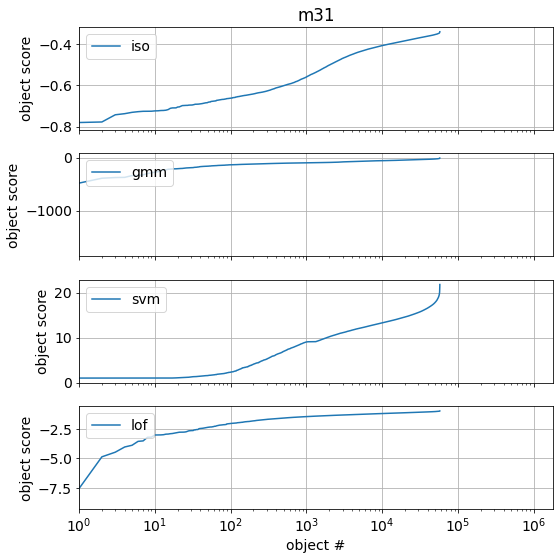

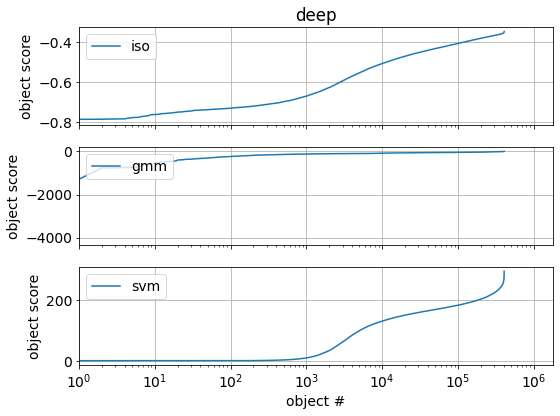

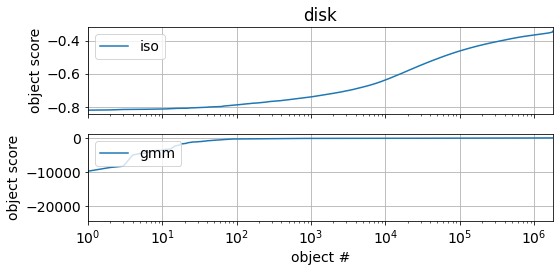

In [8]:
for field in algos_for_fields:
    algo_to_fakes = {}
    n = len(algos_for_fields[field])
    fig, ax = plt.subplots(n, 1, sharex=True, figsize=(8, 2 * n))
    for i, algo in enumerate(algos_for_fields[field]):
        scores = np.memmap('../data/scores/score_{}_{}_fake.dat'.format(field, algo), dtype=np.float64)
        ax[i].plot(np.arange(len(scores)), np.sort(scores), label=algo)
        ax[i].set(ylabel='object score')
        ax[i].legend(loc='upper left')
        ax[i].grid()

    ax[-1].set(xlabel='object #')
    ax[0].set(title=field)
    ax[0].set(xscale='log', xlim=[1, oid_len])
    fig.tight_layout()